In [1]:
%matplotlib inline

======================
Miller Composite Chart
======================
Create a Miller Composite chart based on Miller 1972 in Python with MetPy and
Matplotlib.

In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as lines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import numpy.ma as ma
from scipy.ndimage import gaussian_filter
from siphon.ncss import NCSS

**Get the data**

This example will use data from the North American Mesoscale Model Analysis
(https://nomads.ncdc.gov/) for 12 UTC 27 April 2011.

In [3]:
base_url = 'https://www.ncei.noaa.gov/thredds/ncss/grid/namanl/'
dt = datetime(2011, 4, 27)
ncss = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
            '1800_000.grb'.format(base_url, dt=dt))

# Query for required variables
gfsdata = ncss.query().all_times()
gfsdata.variables('Geopotential_height_isobaric',
                  'u-component_of_wind_isobaric',
                  'v-component_of_wind_isobaric',
                  'Temperature_isobaric',
                  'Relative_humidity_isobaric',
                  'Best_4_layer_lifted_index_layer_between_two_pressure_'
                  'difference_from_ground_layer',
                  'Absolute_vorticity_isobaric',
                  'Pressure_reduced_to_MSL_msl',
                  'Dew_point_temperature_height_above_ground'
                  ).add_lonlat()

# Set the lat/lon box for the data to pull in.
gfsdata.lonlat_box(-135, -60, 15, 65)

# Actually getting the data
data = ncss.get_data(gfsdata)

# Assign variable names to collected data
dtime = data.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data.variables['Geopotential_height_isobaric'].dimensions[1]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = units.hPa * data.variables[dlev][:]
times = data.variables[dtime]
vtimes = num2date(times[:], times.units)
temps = data.variables['Temperature_isobaric']
tmp = units.kelvin * temps[0, :]
uwnd = (units.meter / units.second) * data.variables['u-component_of_wind_isobaric'][0, :]
vwnd = (units.meter / units.second) * data.variables['v-component_of_wind_isobaric'][0, :]
hgt = units.meter * data.variables['Geopotential_height_isobaric'][0, :]
relh = data.variables['Relative_humidity_isobaric'][0, :]
lifted_index = (data.variables['Best_4_layer_lifted_index_layer_between_two_'
                               'pressure_difference_from_ground_layer'][0, 0, :] *
                units(data.variables['Best_4_layer_lifted_index_layer_between_two_'
                                     'pressure_difference_from_ground_layer'].units))
Td_sfc = (units(data.variables['Dew_point_temperature_height_above_ground'].units) *
          data.variables['Dew_point_temperature_height_above_ground'][0, 0, :])
avor = data.variables['Absolute_vorticity_isobaric'][0, :] * units('1/s')
pmsl = (units(data.variables['Pressure_reduced_to_MSL_msl'].units) *
        data.variables['Pressure_reduced_to_MSL_msl'][0, :])


Query for 00 UTC to calculate pressure falls and height change

In [4]:
ncss2 = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
             '0600_000.grb'.format(base_url, dt=dt))

# Query for required variables
gfsdata = ncss.query().all_times()
gfsdata.variables('Geopotential_height_isobaric',
                  'Pressure_reduced_to_MSL_msl',
                  ).add_lonlat()

# Set the lat/lon box for the data you want to pull in.
gfsdata.lonlat_box(-135, -60, 15, 65)

# Actually getting the data
data2 = ncss2.get_data(gfsdata)

hgt_00z = data2.variables['Geopotential_height_isobaric'][0, :] * units.meter
pmsl_00z = (units(data2.variables['Pressure_reduced_to_MSL_msl'].units) *
            data2.variables['Pressure_reduced_to_MSL_msl'][0, :])


**Subset the Data**

With the data pulled in, we will now subset to the specific levels desired

In [5]:
# 300 hPa, index 28
idx_300 = np.where(lev == 300. * units.hPa)[0][0]
u_300 = uwnd[idx_300, :].to('kt')
v_300 = vwnd[idx_300, :].to('kt')

# 500 hPa, index 20
idx_500 = np.where(lev == 500. * units.hPa)[0][0]
avor_500 = avor[1, ]
u_500 = uwnd[idx_500, ].to('kt')
v_500 = vwnd[idx_500, ].to('kt')
hgt_500 = hgt[idx_500, ]
hgt_500_00z = hgt_00z[idx_500, ]

# 700 hPa, index 12
idx_700 = np.where(lev == 700. * units.hPa)[0][0]
tmp_700 = tmp[idx_700, ].to('degC')
rh_700 = relh[idx_700, ] * units.percent

# 850 hPa, index 6
idx_850 = np.where(lev == 850. * units.hPa)[0][0]
u_850 = uwnd[idx_850, ].to('kt')
v_850 = vwnd[idx_850, ].to('kt')

**Prepare Variables for Plotting**

With the data queried and subset, we will make any needed calculations in preparation for
plotting.

**The following fields should be plotted:**

  500-hPa cyclonic vorticity advection

  Surface-based Lifted Index

  The axis of the 300-hPa, 500-hPa, and 850-hPa jets

  Surface dewpoint

  700-hPa dewpoint depression

  12-hr surface pressure falls and 500-hPa height changes

In [6]:

# 500 hPa CVA
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
vort_adv_500 = mpcalc.advection(avor_500, [u_500.to('m/s'), v_500.to('m/s')],
                                (dx, dy), dim_order='yx') * 1e9
vort_adv_500_smooth = gaussian_filter(vort_adv_500, 4)

For the jet axes, we will calculate the windspeed at each level, and plot the highest values

In [7]:
wspd_300 = gaussian_filter(mpcalc.wind_speed(u_300, v_300), 5)
wspd_500 = gaussian_filter(mpcalc.wind_speed(u_500, v_500), 5)
wspd_850 = gaussian_filter(mpcalc.wind_speed(u_850, v_850), 5)

700-hPa dewpoint depression will be calculated from Temperature_isobaric and RH

In [8]:
Td_dep_700 = tmp_700 - mpcalc.dewpoint_rh(tmp_700, rh_700 / 100.)

12-hr surface pressure falls and 500-hPa height changes

In [9]:
pmsl_change = pmsl - pmsl_00z
hgt_500_change = hgt_500 - hgt_500_00z

To plot the jet axes, we will mask the wind fields below the upper 1/3 of windspeed.

In [10]:
mask_500 = ma.masked_less_equal(wspd_500, 0.66 * np.max(wspd_500)).mask
u_500[mask_500] = np.nan
v_500[mask_500] = np.nan

# 300 hPa
mask_300 = ma.masked_less_equal(wspd_300, 0.66 * np.max(wspd_300)).mask
u_300[mask_300] = np.nan
v_300[mask_300] = np.nan

# 850 hPa
mask_850 = ma.masked_less_equal(wspd_850, 0.66 * np.max(wspd_850)).mask
u_850[mask_850] = np.nan
v_850[mask_850] = np.nan

**Create the Plot**

With the data now ready, we will create the plot

In [11]:

# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)


# Coordinates to limit map area
bounds = [-122., -75., 25., 50.]

Plot the composite

/home/travis/miniconda/envs/training/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1833: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/travis/miniconda/envs/training/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1833: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


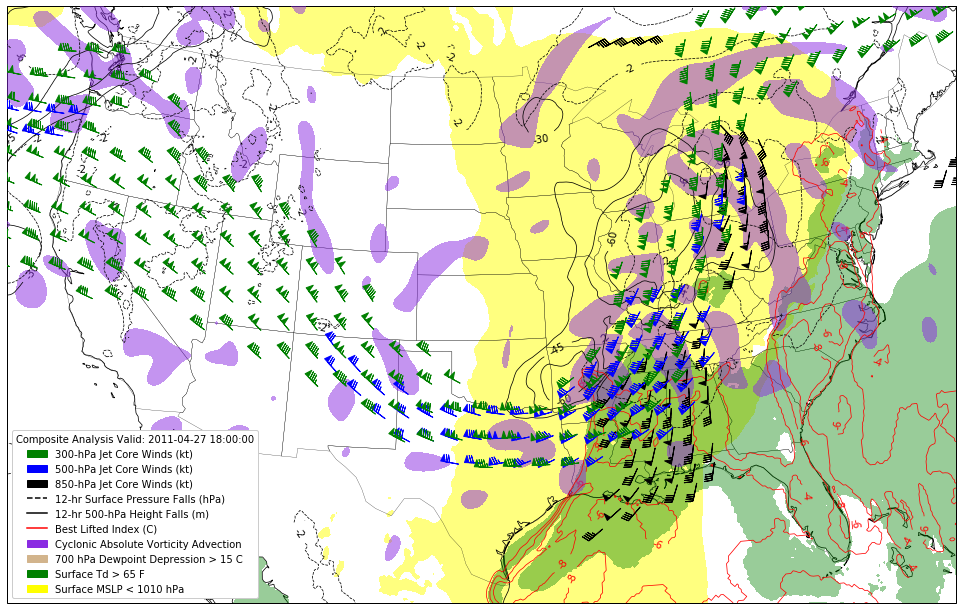

In [12]:
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.25)

# Plot Lifted Index
cs1 = ax.contour(lon, lat, lifted_index, range(-8, -2, 2), transform=ccrs.PlateCarree(),
                 colors='red', linewidths=0.75, linestyles='solid', zorder=7)
cs1.clabel(fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Surface pressure falls
cs2 = ax.contour(lon, lat, pmsl_change.to('hPa'), range(-10, -1, 4),
                 transform=ccrs.PlateCarree(),
                 colors='k', linewidths=0.75, linestyles='dashed', zorder=6)
cs2.clabel(fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot 500-hPa height falls
cs3 = ax.contour(lon, lat, hgt_500_change, range(-60, -29, 15),
                 transform=ccrs.PlateCarree(), colors='k', linewidths=0.75,
                 linestyles='solid', zorder=5)
cs3.clabel(fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot surface pressure
ax.contourf(lon, lat, pmsl.to('hPa'), range(990, 1011, 20), alpha=0.5,
            transform=ccrs.PlateCarree(),
            colors='yellow', zorder=1)

# Plot surface dewpoint
ax.contourf(lon, lat, Td_sfc.to('degF'), range(65, 76, 10), alpha=0.4,
            transform=ccrs.PlateCarree(),
            colors=['green'], zorder=2)

# Plot 700-hPa dewpoint depression
ax.contourf(lon, lat, Td_dep_700, range(15, 46, 30), alpha=0.5, transform=ccrs.PlateCarree(),
            colors='tan', zorder=3)

# Plot Vorticity Advection
ax.contourf(lon, lat, vort_adv_500_smooth, range(5, 106, 100), alpha=0.5,
            transform=ccrs.PlateCarree(),
            colors='BlueViolet', zorder=4)

# Define a skip to reduce the barb point density
skip_300 = (slice(None, None, 12), slice(None, None, 12))
skip_500 = (slice(None, None, 10), slice(None, None, 10))
skip_850 = (slice(None, None, 8), slice(None, None, 8))

# 300-hPa wind barbs
jet300 = ax.barbs(lon[skip_300], lat[skip_300], u_300[skip_300].m, v_300[skip_300].m, length=6,
                  transform=ccrs.PlateCarree(),
                  color='green', zorder=10, label='300-hPa Jet Core Winds (kt)')


# 500-hPa wind barbs
jet500 = ax.barbs(lon[skip_500], lat[skip_500], u_500[skip_500].m, v_500[skip_500].m, length=6,
                  transform=ccrs.PlateCarree(),
                  color='blue', zorder=9, label='500-hPa Jet Core Winds (kt)')

# 850-hPa wind barbs
jet850 = ax.barbs(lon[skip_850], lat[skip_850], u_850[skip_850].m, v_850[skip_850].m, length=6,
                  transform=ccrs.PlateCarree(),
                  color='k', zorder=8, label='850-hPa Jet Core Winds (kt)')

# Legend
purple = mpatches.Patch(color='BlueViolet', label='Cyclonic Absolute Vorticity Advection')
yellow = mpatches.Patch(color='yellow', label='Surface MSLP < 1010 hPa')
green = mpatches.Patch(color='green', label='Surface Td > 65 F')
tan = mpatches.Patch(color='tan', label='700 hPa Dewpoint Depression > 15 C')
red_line = lines.Line2D([], [], color='red', label='Best Lifted Index (C)')
dashed_black_line = lines.Line2D([], [], linestyle='dashed', color='k',
                                 label='12-hr Surface Pressure Falls (hPa)')
black_line = lines.Line2D([], [], linestyle='solid', color='k',
                          label='12-hr 500-hPa Height Falls (m)')
leg = plt.legend(handles=[jet300, jet500, jet850, dashed_black_line, black_line, red_line,
                          purple, tan, green, yellow], loc=3,
                 title='Composite Analysis Valid: {:s}'.format(str(vtimes[0])),
                 framealpha=1)
leg.set_zorder(100)

plt.show()